In [1]:
# Cell 1: Environment Setup and Dataset Download via Kaggle API

# Install kaggle library quietly
!pip install -q kaggle

import os
from google.colab import files

print("Please upload your kaggle.json file:")
# Prompt user to upload kaggle.json
uploaded = files.upload()

# Move kaggle.json to the correct directory and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the LiTS dataset
print("Downloading LiTS dataset from Kaggle...")
!kaggle datasets download -d andrewmvd/liver-tumor-segmentation

# Unzip the dataset into a specific folder
print("Extracting dataset... This might take a few minutes.")
!unzip -q liver-tumor-segmentation.zip -d ./LiTS17

print("Cell 1 executed: Dataset downloaded and extracted successfully!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/liver-tumor-segmentation
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 4.84G/4.84G [01:08<00:00, 39.2MB/s]
100% 4.84G/4.84G [01:08<00:00, 75.3MB/s]
Extracting dataset... This might take a few minutes.
Cell 1 executed: Dataset downloaded and extracted successfully!


In [2]:
# Cell 2: Imports and Data Discovery

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models

# Base directory where dataset was extracted
base_path = './LiTS17'

# Dynamically find all volume and segmentation .nii files
# Using recursive=True to search through all subdirectories (volume-pt1, pt2, etc.)
volume_paths = sorted(glob.glob(os.path.join(base_path, '**', 'volume-*.nii'), recursive=True))
mask_paths = sorted(glob.glob(os.path.join(base_path, '**', 'segmentation-*.nii'), recursive=True))

print(f"Total CT volumes found: {len(volume_paths)}")
print(f"Total segmentation masks found: {len(mask_paths)}")

# Load the first volume and mask to check their dimensions
if len(volume_paths) > 0 and len(mask_paths) > 0:
    print("Loading sample volume to check shapes (this might take a few seconds)...")
    sample_vol = nib.load(volume_paths[0]).get_fdata()
    sample_mask = nib.load(mask_paths[0]).get_fdata()

    print(f"Sample Volume Shape: {sample_vol.shape}")
    print(f"Sample Mask Shape: {sample_mask.shape}")
else:
    print("Error: Could not find the .nii files. Please check the extraction path.")

Total CT volumes found: 51
Total segmentation masks found: 131
Loading sample volume to check shapes (this might take a few seconds)...
Sample Volume Shape: (512, 512, 75)
Sample Mask Shape: (512, 512, 75)


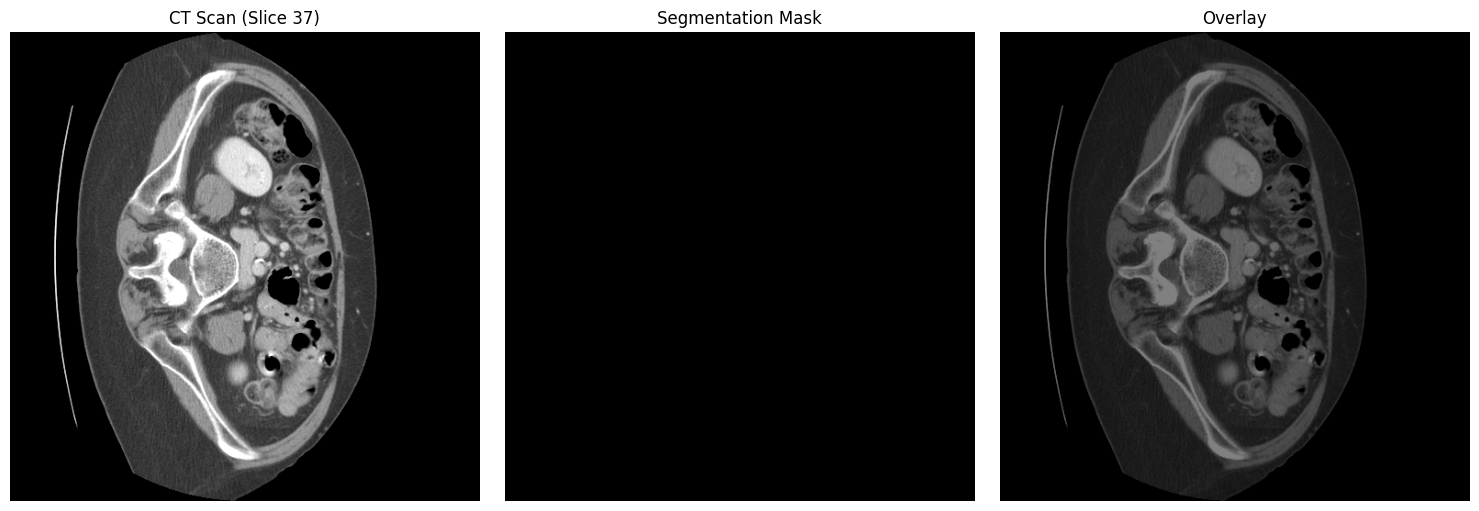

In [3]:
# Cell 3: Visualizing a CT Slice and its corresponding Mask

import matplotlib.pyplot as plt
import numpy as np

# Select a slice from the middle of the volume where liver is usually visible
slice_idx = sample_vol.shape[2] // 2

img_slice = sample_vol[:, :, slice_idx]
mask_slice = sample_mask[:, :, slice_idx]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. CT Scan Slice
# Clipping values to improve visibility (standard windowing for soft tissue in CT)
img_clipped = np.clip(img_slice, -200, 250)
axes[0].imshow(img_clipped, cmap='gray')
axes[0].set_title(f'CT Scan (Slice {slice_idx})')
axes[0].axis('off')

# 2. Ground Truth Mask
# Mask values in LiTS: 0 (background), 1 (liver), 2 (tumor)
axes[1].imshow(mask_slice, cmap='nipy_spectral')
axes[1].set_title('Segmentation Mask')
axes[1].axis('off')

# 3. Overlay
axes[2].imshow(img_clipped, cmap='gray')
axes[2].imshow(mask_slice, cmap='nipy_spectral', alpha=0.5)
axes[2].set_title('Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Cell 4: PyTorch Dataset and DataLoader

import os
import cv2
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16 # برای پایتورچ روی کولب معمولا ۱۶ بهینه‌تره تا رم کم نیاد

# Match volumes and masks accurately
valid_volumes = []
valid_masks = []

for vol_path in volume_paths:
    vol_name = os.path.basename(vol_path)
    vol_num = vol_name.replace('volume-', '').replace('.nii', '')

    mask_path = next((m for m in mask_paths if f'segmentation-{vol_num}.nii' in m), None)
    if mask_path:
        valid_volumes.append(vol_path)
        valid_masks.append(mask_path)

# Split into 80% training and 20% validation at the volume level
train_vol, val_vol, train_mask, val_mask = train_test_split(
    valid_volumes, valid_masks, test_size=0.2, random_state=42
)

class LiTSDataset(Dataset):
    def __init__(self, vol_paths, mask_paths):
        self.vol_paths = vol_paths
        self.mask_paths = mask_paths
        self.slices_info = []

        print(f"Scanning {len(vol_paths)} volumes for valid slices... (This takes a moment)")
        # Pre-scan to find slices that contain liver/tumor
        for v_path, m_path in zip(vol_paths, mask_paths):
            mask_data = nib.load(m_path).get_fdata()
            valid_z = np.where(np.sum(mask_data, axis=(0, 1)) > 0)[0]
            for z in valid_z:
                self.slices_info.append((v_path, m_path, z))

        print(f"Found {len(self.slices_info)} valid slices with liver tissue.")

    def __len__(self):
        return len(self.slices_info)

    def __getitem__(self, idx):
        v_path, m_path, z = self.slices_info[idx]

        # Lazy loading of a specific slice using dataobj (saves RAM)
        img_slice = nib.load(v_path).dataobj[:, :, z]
        mask_slice = nib.load(m_path).dataobj[:, :, z]

        # 1. Windowing (-200 to 250 HU for soft tissue)
        img_clipped = np.clip(img_slice, -200, 250)

        # 2. Normalization to [0, 1]
        img_norm = (img_clipped - (-200)) / (250 - (-200))

        # 3. Resizing
        img_resized = cv2.resize(img_norm, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
        mask_resized = cv2.resize(mask_slice, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)

        # 4. Binarize Mask
        mask_binary = (mask_resized > 0).astype(np.float32)

        # 5. Convert to PyTorch Tensors and adjust shape to (C, H, W)
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0)
        mask_tensor = torch.tensor(mask_binary, dtype=torch.float32).unsqueeze(0)

        return img_tensor, mask_tensor

# Initialize Datasets and DataLoaders
train_dataset = LiTSDataset(train_vol, train_mask)
val_dataset = LiTSDataset(val_vol, val_mask)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Verify the shapes
sample_images, sample_masks = next(iter(train_loader))
print(f"PyTorch Image Batch Shape: {sample_images.shape}")
print(f"PyTorch Mask Batch Shape: {sample_masks.shape}")

Scanning 40 volumes for valid slices... (This takes a moment)
Found 5463 valid slices with liver tissue.
Scanning 11 volumes for valid slices... (This takes a moment)
Found 1339 valid slices with liver tissue.
PyTorch Image Batch Shape: torch.Size([16, 1, 256, 256])
PyTorch Mask Batch Shape: torch.Size([16, 1, 256, 256])


In [5]:
# Cell 5: Model Architecture and Loss Function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

class DiceLoss(nn.Module):
    """Dice Loss with smoothing"""
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)

        preds_flat = preds.contiguous().view(-1)
        targets_flat = targets.contiguous().view(-1)

        intersection = (preds_flat * targets_flat).sum()
        dice = (2. * intersection + self.smooth) / (preds_flat.sum() + targets_flat.sum() + self.smooth)

        return 1 - dice

class EnhancedUNet(nn.Module):
    """Enhanced U-Net Architecture"""
    def __init__(self, in_channels=1, out_channels=1, base_channels=32):
        super(EnhancedUNet, self).__init__()

        # Encoder
        self.enc1 = self._conv_block(in_channels, base_channels)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = self._conv_block(base_channels, base_channels * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = self._conv_block(base_channels * 2, base_channels * 4)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self._conv_block(base_channels * 4, base_channels * 8)

        # Decoder
        self.up3 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, kernel_size=2, stride=2)
        self.dec3 = self._conv_block(base_channels * 8, base_channels * 4)

        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.dec2 = self._conv_block(base_channels * 4, base_channels * 2)

        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.dec1 = self._conv_block(base_channels * 2, base_channels)

        # Output
        self.final = nn.Conv2d(base_channels, out_channels, kernel_size=1)

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))

        # Bottleneck
        b = self.bottleneck(self.pool3(e3))

        # Decoder
        d3 = self.up3(b)
        d3 = torch.cat([e3, d3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([e2, d2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([e1, d1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)

# Ensure GPU is used if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedUNet(in_channels=1, out_channels=1).to(device)

print(f"Model initialized and moved to {device} successfully!")

Model initialized and moved to cuda successfully!


In [6]:
# Cell 6: Training Loop with Early Stopping

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

# Hyperparameters and Configurations
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
SAVE_DIR = './'
EARLY_STOPPING_PATIENCE = 10

# Create directory for saving models
os.makedirs(f'{SAVE_DIR}/models', exist_ok=True)

def train_model(model, train_loader, val_loader, device, num_epochs=50):
    """Training the model with Early Stopping"""
    criterion = DiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # آرگومان verbose=True برای سازگاری با نسخه‌های جدید پایتورچ حذف شد
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

    best_dice = 0
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    val_dice_scores = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)

        # Training Phase
        model.train()
        epoch_train_loss = 0

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, masks)
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_train_loss += loss.item()

            # Print progress every 25% of the batches
            if batch_idx % max(1, len(train_loader)//4) == 0:
                print(f"  Batch {batch_idx}/{len(train_loader)}: Loss={loss.item():.4f}")

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Phase
        model.eval()
        epoch_val_loss = 0
        val_dice = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)

                loss = criterion(outputs, masks)
                epoch_val_loss += loss.item()

                # Calculate Dice Score
                preds = torch.sigmoid(outputs)
                preds_bin = (preds > 0.5).float()

                intersection = (preds_bin * masks).sum()
                union = preds_bin.sum() + masks.sum()
                dice = (2. * intersection) / (union + 1e-7)

                val_dice += dice.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)

        val_losses.append(avg_val_loss)
        val_dice_scores.append(avg_val_dice)

        # Update learning rate based on validation Dice score
        scheduler.step(avg_val_dice)
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss:   {avg_val_loss:.4f}")
        print(f"Val Dice:   {avg_val_dice:.4f}")
        print(f"LR:         {current_lr:.6f}")

        # Early Stopping and Save the best model
        if avg_val_dice > best_dice:
            best_dice = avg_val_dice
            epochs_no_improve = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_dice': best_dice,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'val_dice_scores': val_dice_scores
            }, f'{SAVE_DIR}/models/best_model.pth')
            print(f"✓ New best model saved! Dice: {best_dice:.4f}")
        else:
            epochs_no_improve += 1
            print(f"⚠ No improvement for {epochs_no_improve} epochs.")
            if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
                print(f"⏹ Early stopping triggered after {epoch+1} epochs! Best Dice: {best_dice:.4f}")
                break

    return train_losses, val_losses, val_dice_scores

# Start training!
print("Starting training process...")
train_history, val_history, dice_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=NUM_EPOCHS
)

Starting training process...

Epoch 1/50
--------------------------------------------------
  Batch 0/342: Loss=0.9194
  Batch 85/342: Loss=0.6741
  Batch 170/342: Loss=0.6232
  Batch 255/342: Loss=0.5710
  Batch 340/342: Loss=0.5448
Train Loss: 0.6426
Val Loss:   0.5808
Val Dice:   0.8727
LR:         0.000100
✓ New best model saved! Dice: 0.8727

Epoch 2/50
--------------------------------------------------
  Batch 0/342: Loss=0.4986
  Batch 85/342: Loss=0.5059
  Batch 170/342: Loss=0.4508
  Batch 255/342: Loss=0.4599
  Batch 340/342: Loss=0.4787
Train Loss: 0.4782
Val Loss:   0.4686
Val Dice:   0.9010
LR:         0.000100
✓ New best model saved! Dice: 0.9010

Epoch 3/50
--------------------------------------------------
  Batch 0/342: Loss=0.4257
  Batch 85/342: Loss=0.3707
  Batch 170/342: Loss=0.4649
  Batch 255/342: Loss=0.3232
  Batch 340/342: Loss=0.2663
Train Loss: 0.3367
Val Loss:   0.3559
Val Dice:   0.9223
LR:         0.000100
✓ New best model saved! Dice: 0.9223

Epoch 4/50